In [1]:
### import libraries

# format
import pandas as pd

# plot
import matplotlib.pyplot as plt

# math
import numpy as np
import math
from scipy.linalg import inv, det
from numpy.linalg import eig

from scipy import stats

#kmeans 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#kmeans mixto
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import roc_curve
from dython.nominal import associations
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
data_raw = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")


In [5]:
### Preprocess Data
data = data_raw.copy()

# rename columns for easier use
rename_dict = {
    'Person ID':'person_id',
    'Gender': 'gender',
    'Age':'age',
    'Occupation':'occupation',
    'Sleep Duration':'sleep_duration',
    'Quality of Sleep':'quality_of_sleep',
    'Physical Activity Level':'physical_activity_level',
    'Stress Level':'stress_level',
    'BMI Category':'bmi_category', 
    'Blood Pressure':'blood_pressure', 
    'Heart Rate':'heart_rate', 
    'Daily Steps':'daily_steps',
    'Sleep Disorder':'sleep_disorder' 
}
data.rename(columns=rename_dict, inplace=True)

# change dtype
data['quality_of_sleep'] = data['quality_of_sleep'].astype(str)
data['stress_level'] = data['stress_level'].astype(str)

# make sleep disorder binary
data['sleep_disorder'] = data['sleep_disorder'].map(lambda x: '1' if x in ['Insomnia','Sleep Apnea'] else '0').astype(str)

# split blood pressure into diastolic & systolic
data[["blood_pressure_systolic","blood_pressure_diastolic"]] = data["blood_pressure"].str.split('/',expand=True)
data["blood_pressure_diastolic"] = pd.to_numeric(data['blood_pressure_diastolic'])
data["blood_pressure_systolic"] = pd.to_numeric(data["blood_pressure_systolic"])


#data.info()

In [6]:
# # set up column lists
numeric_variables = ['age','sleep_duration','physical_activity_level','heart_rate','daily_steps','blood_pressure_systolic','blood_pressure_diastolic']
categorical_variables = ['gender','occupation','quality_of_sleep','stress_level','bmi_category','sleep_disorder']
# data.nunique()

In [7]:
data_kprot = data[numeric_variables+categorical_variables]

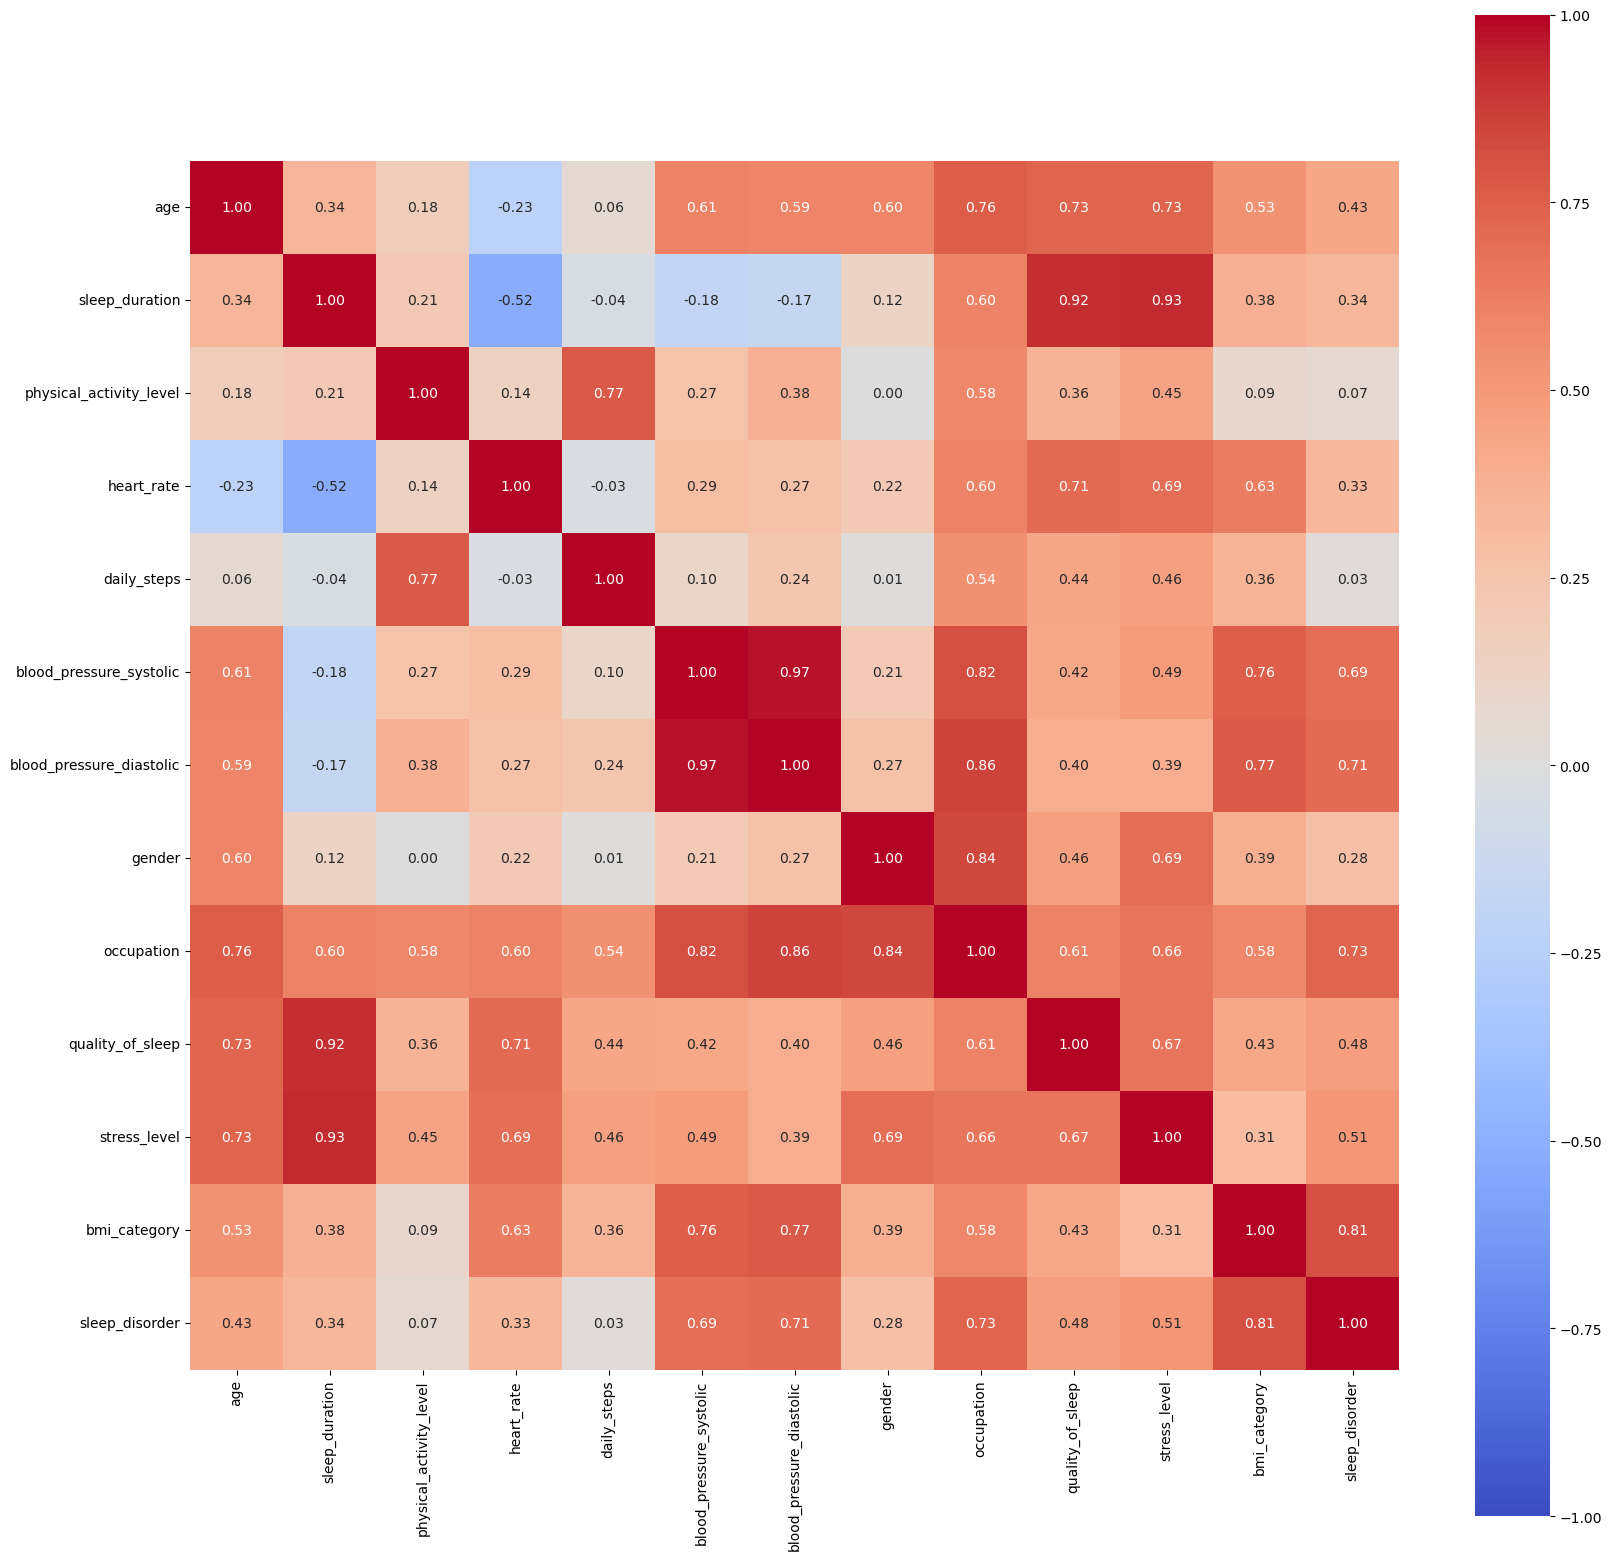

{'corr':                                age  sleep_duration  physical_activity_level  \
 age                       1.000000        0.344709                 0.178993   
 sleep_duration            0.344709        1.000000                 0.212360   
 physical_activity_level   0.178993        0.212360                 1.000000   
 heart_rate               -0.225606       -0.516455                 0.136971   
 daily_steps               0.057973       -0.039533                 0.772723   
 blood_pressure_systolic   0.605878       -0.180406                 0.265416   
 blood_pressure_diastolic  0.593839       -0.166570                 0.382651   
 gender                    0.596358        0.121579                 0.001454   
 occupation                0.760778        0.601955                 0.584159   
 quality_of_sleep          0.732920        0.917586                 0.364516   
 stress_level              0.732444        0.926912                 0.445907   
 bmi_category              0.532

In [8]:
plt.rcParams["figure.figsize"]=18,18
associations(data_kprot,nominal_columns=categorical_variables, plot=True,cmap="coolwarm")

The variables blood pressure systolic and blood pressure diastolic are to correlated. For not losing the information removing one of them. We created a variable that it's call Pulse pressure. This is the difference between the two blood pressure.


In [9]:
data_kprot["pulse_pressure"] = data_kprot['blood_pressure_systolic']-data_kprot['blood_pressure_diastolic'] 

In [10]:
data_kprot[numeric_variables+['pulse_pressure']] = StandardScaler().fit_transform(data_kprot[numeric_variables+['pulse_pressure']])
data_kprot = data_kprot.drop(columns=['blood_pressure_systolic','blood_pressure_diastolic'])
data_kprot.head()

,age,sleep_duration,physical_activity_level,heart_rate,daily_steps,gender,occupation,quality_of_sleep,stress_level,bmi_category,sleep_disorder,pulse_pressure
0,-1.753096,-1.298887,-0.825418,1.654719,-1.619584,Male,Software Engineer,6,6,Overweight,0,-0.400485
1,-1.637643,-1.173036,0.039844,1.170474,1.970077,Male,Doctor,6,8,Normal,0,0.485796
2,-1.637643,-1.173036,0.039844,1.170474,1.970077,Male,Doctor,6,8,Normal,0,0.485796
3,-1.637643,-1.550588,-1.402260,3.591698,-2.362273,Male,Sales Representative,4,8,Obese,1,2.701498
4,-1.637643,-1.550588,-1.402260,3.591698,-2.362273,Male,Sales Representative,4,8,Obese,1,2.701498


In [11]:
label_encoders = {}
for col in categorical_variables:
    le = LabelEncoder()
    data_kprot[col] = le.fit_transform(data_kprot[col])
    label_encoders[col] = le

In [12]:
data_kprot.columns

Index(['age', 'sleep_duration', 'physical_activity_level', 'heart_rate',
       'daily_steps', 'gender', 'occupation', 'quality_of_sleep',
       'stress_level', 'bmi_category', 'sleep_disorder', 'pulse_pressure'],
      dtype='object')

In [29]:
data_array = data_kprot.to_numpy()

# Perform K-Prototypes clustering
kproto = KPrototypes(n_clusters=4, init='Huang', random_state=42)
clusters = kproto.fit_predict(data_array, categorical=[data_kprot.columns.get_loc(col) for col in categorical_variables])

# Add the cluster labels to the DataFrame
data_kprot['Cluster_4'] = clusters
data_kprot['Cluster_4'] = data_kprot['Cluster_4'].astype('str')
# Display the first few rows of the clustered data
data_kprot.dtypes

age                        float64
sleep_duration             float64
physical_activity_level    float64
heart_rate                 float64
daily_steps                float64
gender                       int32
occupation                   int32
quality_of_sleep             int32
stress_level                 int32
bmi_category                 int32
sleep_disorder               int32
pulse_pressure             float64
Cluster                     object
Cluster_4                   object
dtype: object

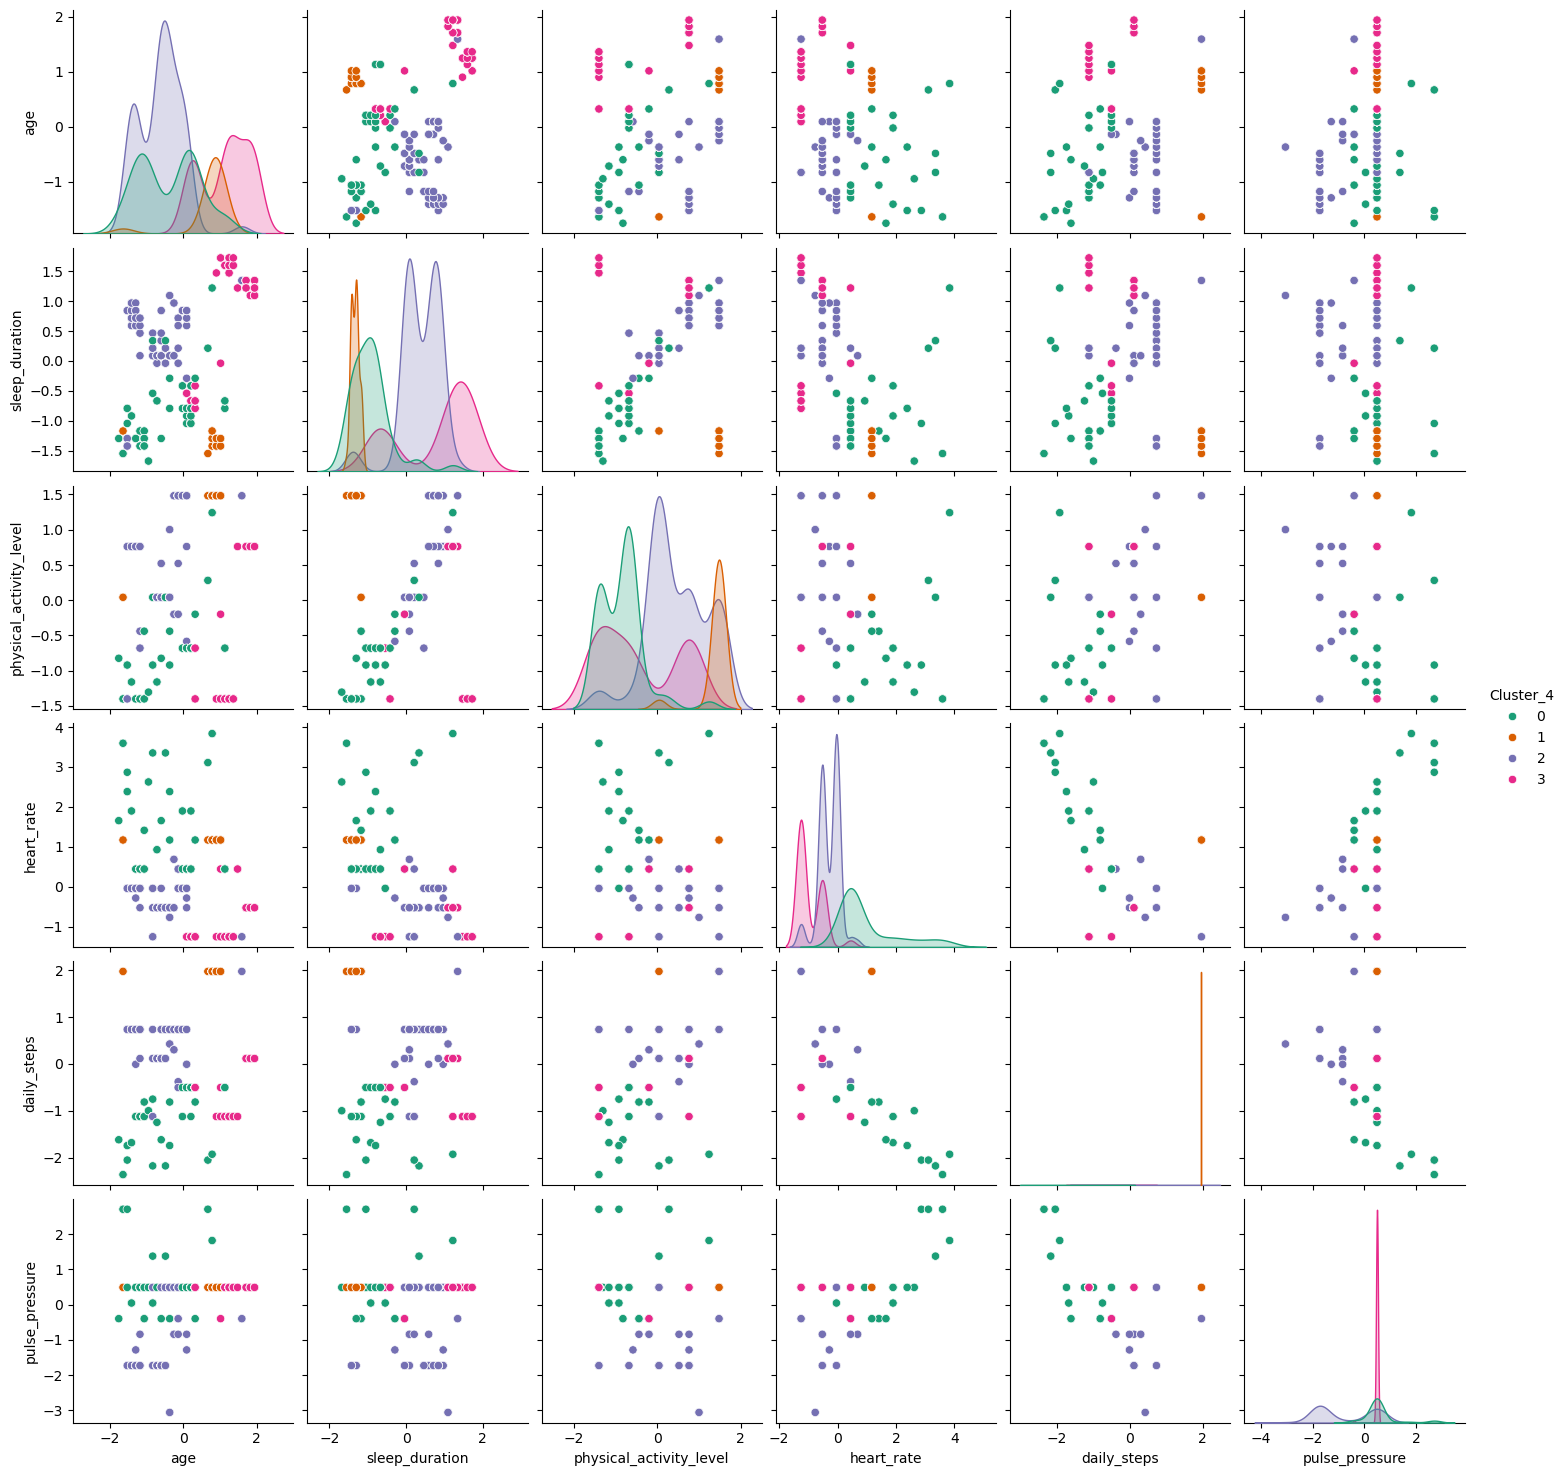

In [30]:
sns.pairplot(data_kprot[['age', 'sleep_duration', 'physical_activity_level', 'heart_rate', 'daily_steps','Cluster_4','pulse_pressure']],hue='Cluster_4',palette='Dark2',diag_kind='kde')

In [ ]:

data_array = data_kprot.to_numpy()

# Perform K-Prototypes clustering
kproto = KPrototypes(n_clusters=6, init='Huang', n_init=4, random_state=42)
clusters = kproto.fit_predict(data_array, categorical=[data_kprot.columns.get_loc(col) for col in categorical_variables])

# Add the cluster labels to the DataFrame
data_kprot['Cluster_6'] = clusters
data_kprot['Cluster_6'] = data_kprot['Cluster_6'].astype('str')
# Display the first few rows of the clustered data
data_kprot.dtypes

age                        float64
sleep_duration             float64
physical_activity_level    float64
heart_rate                 float64
daily_steps                float64
gender                       int32
occupation                   int32
quality_of_sleep             int32
stress_level                 int32
bmi_category                 int32
sleep_disorder               int32
pulse_pressure             float64
Cluster                     object
Cluster_4                   object
Cluster_6                   object
dtype: object

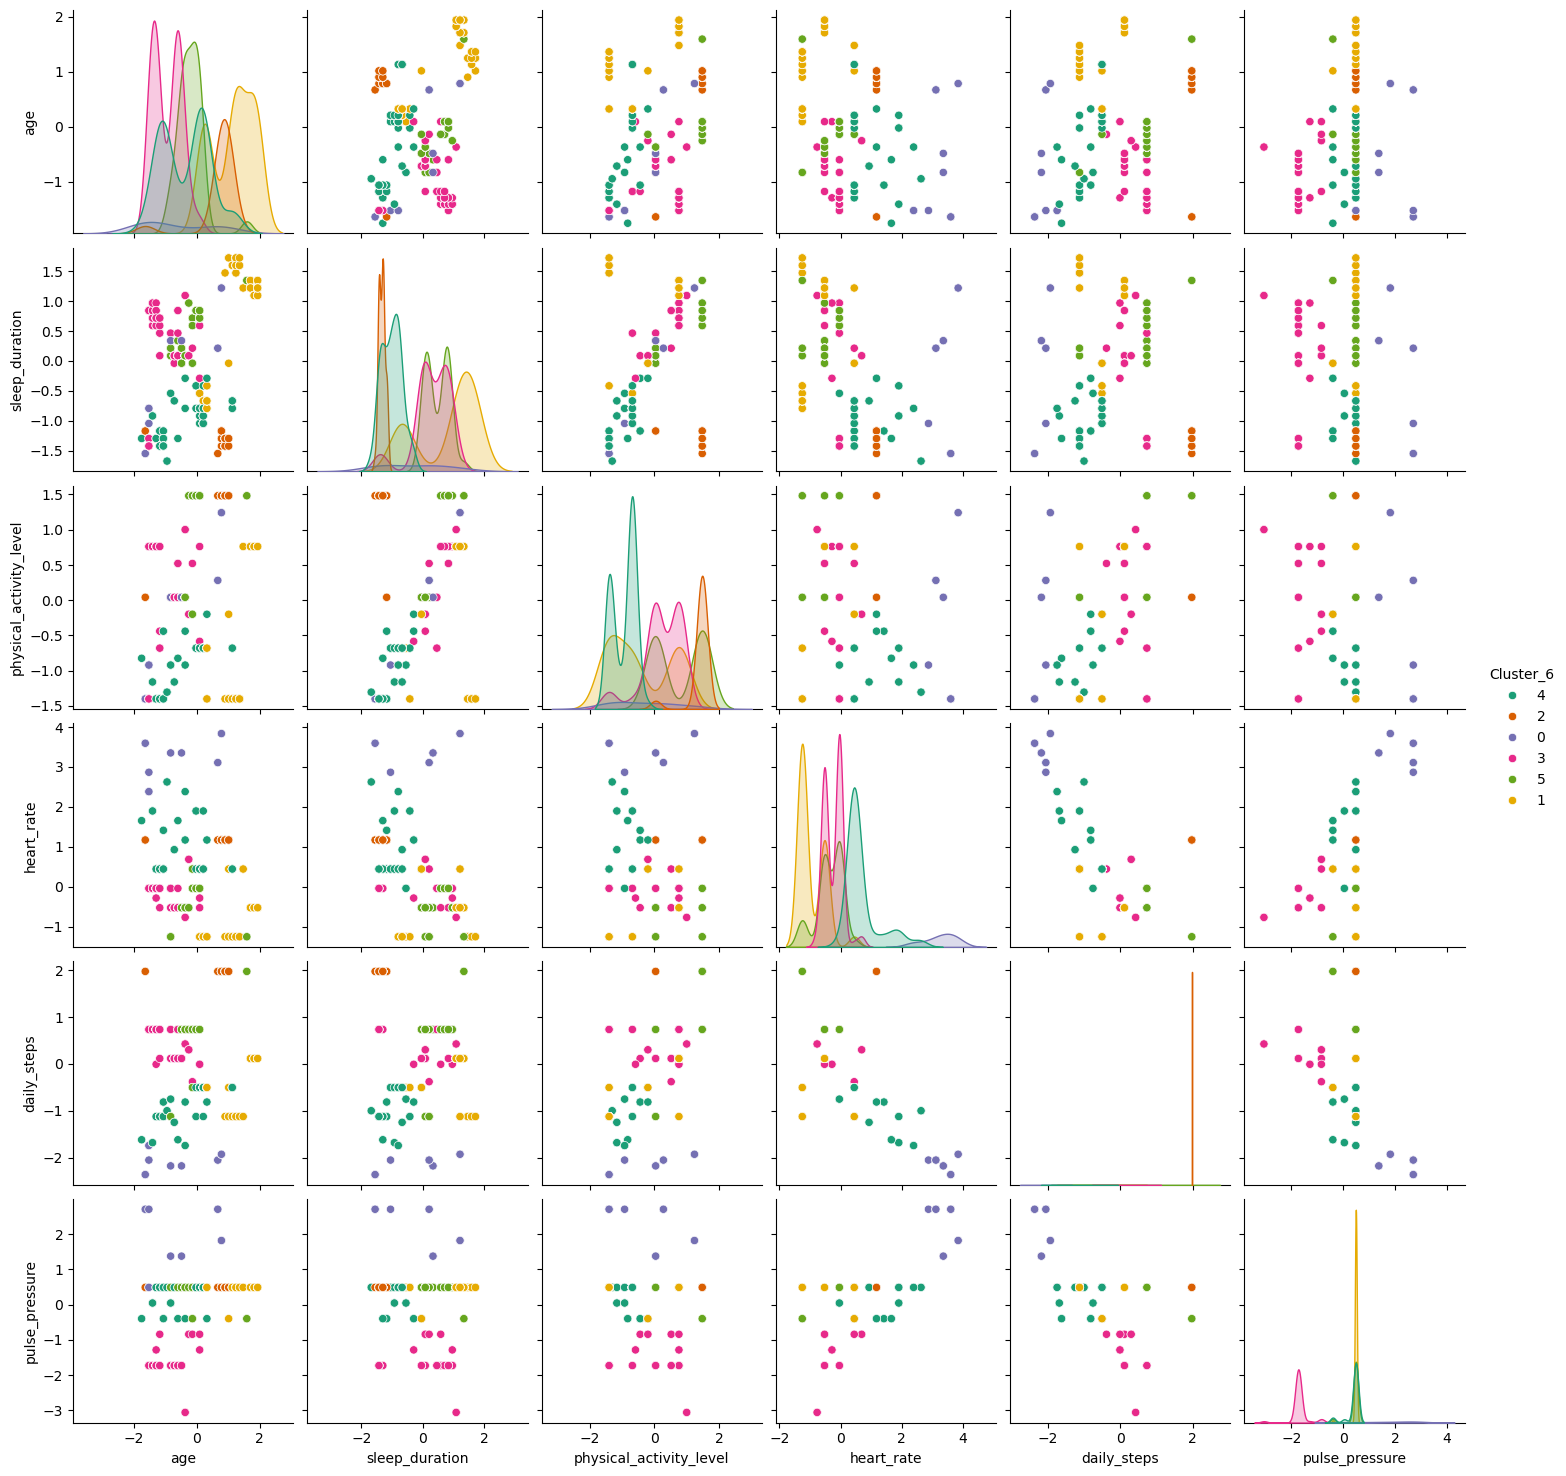

In [32]:
sns.pairplot(data_kprot[['age', 'sleep_duration', 'physical_activity_level', 'heart_rate', 'daily_steps','Cluster_6','pulse_pressure']],hue='Cluster_6',palette='Dark2',diag_kind='kde')

Cluster initiation: 1
[3128.2543695994536]
Cluster initiation: 2
[3128.2543695994536, 2365.43297040082]
Cluster initiation: 3
[3128.2543695994536, 2365.43297040082, 1742.8732144247676]
Cluster initiation: 4
[3128.2543695994536, 2365.43297040082, 1742.8732144247676, 1307.7612234723251]
Cluster initiation: 5
[3128.2543695994536, 2365.43297040082, 1742.8732144247676, 1307.7612234723251, 1132.5325208151194]
Cluster initiation: 6
[3128.2543695994536, 2365.43297040082, 1742.8732144247676, 1307.7612234723251, 1132.5325208151194, 908.9287267608856]
Cluster initiation: 7
[3128.2543695994536, 2365.43297040082, 1742.8732144247676, 1307.7612234723251, 1132.5325208151194, 908.9287267608856, 726.9097044414252]
Cluster initiation: 8
[3128.2543695994536, 2365.43297040082, 1742.8732144247676, 1307.7612234723251, 1132.5325208151194, 908.9287267608856, 726.9097044414252, 599.2710239113867]
Cluster initiation: 9
[3128.2543695994536, 2365.43297040082, 1742.8732144247676, 1307.7612234723251, 1132.5325208151

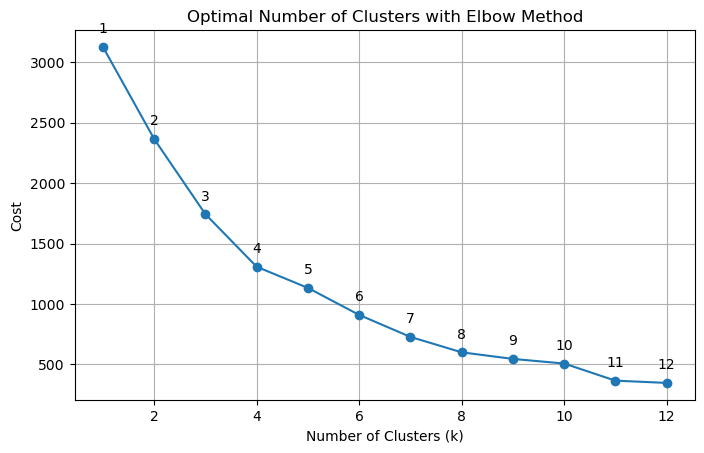

In [26]:
cost = []
# Loop over the range of cluster sizes
for cluster in range(1, 13):
    try:
        # Initialize and fit KPrototypes
        kprototype = KPrototypes(n_jobs=-1, n_clusters=cluster,n_init=30,init='Huang',random_state=123)
        kprototype.fit_predict(data_array, categorical=[data_kprot.columns.get_loc(col) for col in categorical_variables])
        
        # Append the cost to the list
        cost.append(kprototype.cost_)
        print(f'Cluster initiation: {cluster}')
        print(cost)
    except Exception as e:
        print(f"Error for cluster {cluster}: {e}")
        break

# Create a DataFrame for cost data
df_cost = pd.DataFrame({'Cluster': range(1, len(cost) + 1), 'Cost': cost})
# Plot the elbow curve
plt.figure(figsize=(8, 4.8))
plt.plot(df_cost['Cluster'], df_cost['Cost'], marker='o', label='Cost')
plt.title('Optimal Number of Clusters with Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.grid(True)

for i, txt in enumerate(df_cost['Cluster']):
    plt.annotate(txt, (df_cost['Cluster'][i], df_cost['Cost'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Show the plot
plt.show()




Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10
Cluster initiation: 11
Cluster initiation: 12


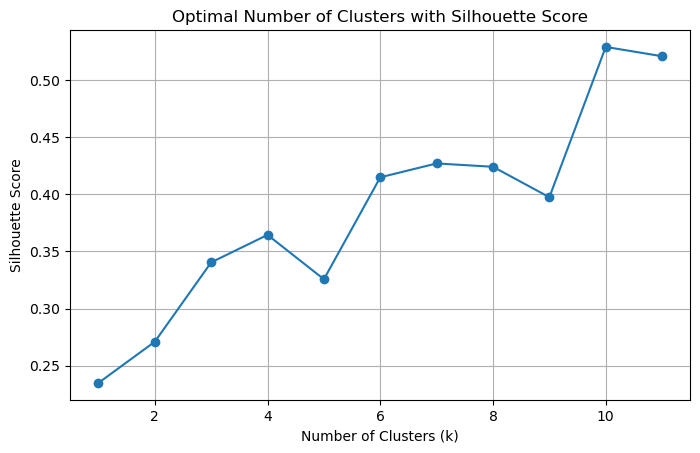

In [25]:
score = []
# Loop over the range of cluster sizes
for cluster in range(2, 13):
    try:
        # Initialize and fit KPrototypes
        kprototype = KPrototypes(n_jobs=-1, n_clusters=cluster,n_init=30,init='Huang',random_state=123)
        kprototype.fit_predict(data_array, categorical=[data_kprot.columns.get_loc(col) for col in categorical_variables])
        
        score_aux = silhouette_score(data_array, kprototype.labels_, metric='euclidean')
        score.append(score_aux)
        print(f'Cluster initiation: {cluster}')
    except Exception as e:
        print(f"Error for cluster {cluster}: {e}")
        break

df_score = pd.DataFrame({'Cluster': range(1, len(score) + 1), 'Score': score})
plt.figure(figsize=(8, 4.8))
plt.plot(df_score['Cluster'], df_score['Score'], marker='o', label='Score')
plt.title('Optimal Number of Clusters with Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
# Show the plot
plt.show()

If we compared the silhouette score and the cost. It look like there's two possible cluster for the data. They are 4 and 6 cluster. 
